In [1]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# using JD as its not as stable
df=web.DataReader('AAPL',data_source='yahoo',start='04-01-2003',end='07-15-2020')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-04-01,1.022143,1.005000,1.014286,1.011429,38585400.0,0.875591
2003-04-02,1.049286,1.019286,1.025714,1.042857,42842800.0,0.902799
2003-04-03,1.050000,1.025000,1.040000,1.032857,36428000.0,0.894142
2003-04-04,1.047857,1.027857,1.037143,1.029286,36505000.0,0.891050
2003-04-07,1.067857,1.029286,1.060714,1.035000,49215600.0,0.895997


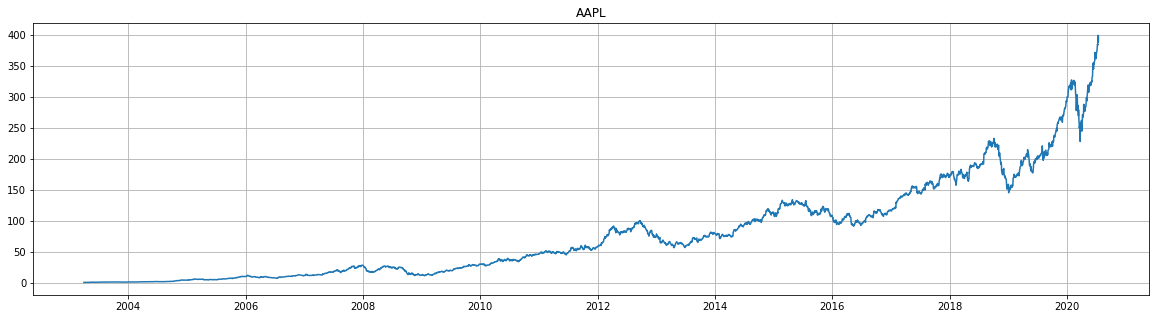

In [28]:
plt.figure(figsize=(20,5))
plt.plot(df.Close)
plt.title("AAPL")
plt.grid()

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing valueŝ
ser = df.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [7]:
int(series.shape[0]*0.9)

3917

In [8]:
# fixed input size to model, last 30 days
Window = 30
Predday = 7

# To split the data into 90:10
Trainsplit = 0.9

cut = int(series.shape[0]*Trainsplit)

# train
closetrain = series[:cut]
# test
closetest = series[cut:-(Window+Predday)]
# forecast for future 7 days
closeforecast = series[-(Window+Predday):]

closetrain.shape, closetest.shape , closeforecast.shape

((3917, 1), (399, 1), (37, 1))

In [9]:
def windowed_dataset(series, window_size = 31,predday = 7, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-7], tf.squeeze(w[-7:])))
    return ds.batch(batch_size).prefetch(3)

trainbatches =  windowed_dataset(closetrain)
testbatches =  windowed_dataset(closetest,batch_size=8)


In [10]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
from tensorflow.keras.models import load_model
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model1_pred_7days.h5'
new_model=load_model(path)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 4

In [15]:
h = new_model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
122/122 [==============================] - 2s 13ms/step - loss: 3.6892e-05 - mean_squared_error: 7.3795e-05 - val_loss: 7.0955e-04 - val_mean_squared_error: 0.0014
Epoch 2/10
122/122 [==============================] - 2s 13ms/step - loss: 3.6844e-05 - mean_squared_error: 7.3697e-05 - val_loss: 7.1510e-04 - val_mean_squared_error: 0.0014
Epoch 3/10
122/122 [==============================] - 2s 13ms/step - loss: 3.6446e-05 - mean_squared_error: 7.2901e-05 - val_loss: 7.0020e-04 - val_mean_squared_error: 0.0014
Epoch 4/10
122/122 [==============================] - 2s 13ms/step - loss: 3.6503e-05 - mean_squared_error: 7.3014e-05 - val_loss: 7.0865e-04 - val_mean_squared_error: 0.0014
Epoch 5/10
122/122 [==============================] - 2s 13ms/step - loss: 3.6427e-05 - mean_squared_error: 7.2863e-05 - val_loss: 7.0920e-04 - val_mean_squared_error: 0.0014
Epoch 6/10
122/122 [==============================] - 2s 13ms/step - loss: 3.6376e-05 - mean_squared_error: 7.2760e-05 - val_

In [16]:
hist.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

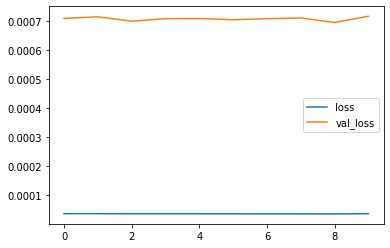

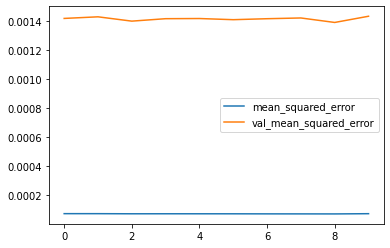

In [27]:
for i in ["loss","mean_squared_error"]:
    plt.plot(hist[i],label = i)
    plt.plot(hist["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()


In [18]:
x1,y1 = next(iter(testbatches))
output = new_model.predict(x1)
output.shape

(8, 7)

In [ ]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

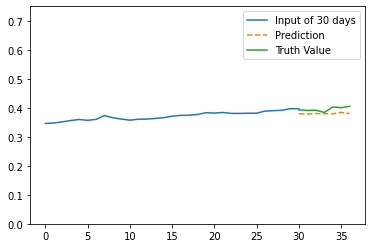

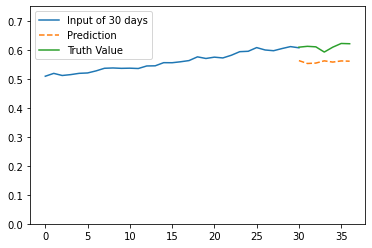

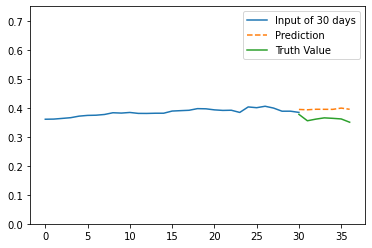

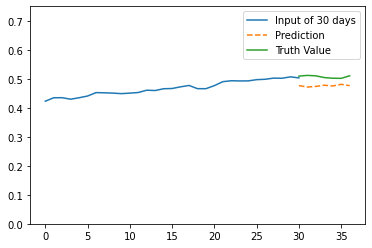

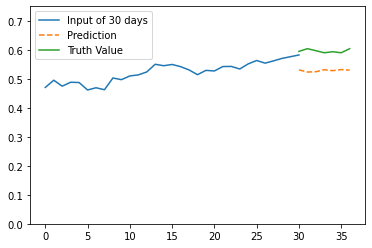

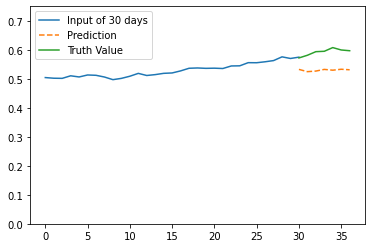

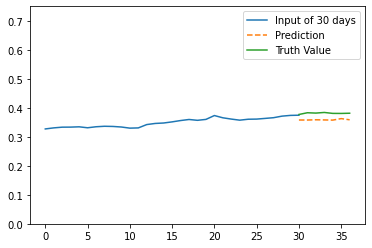

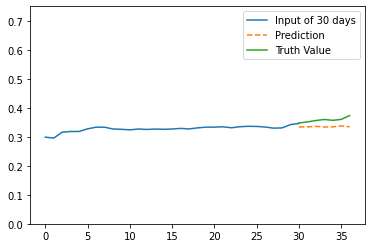

In [21]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = new_model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [23]:
new_model.evaluate(testbatches)

46/46 [==============================] - 0s 5ms/step - loss: 7.1709e-04 - mean_squared_error: 0.0014


[0.0007170944008976221, 0.0014353505102917552]

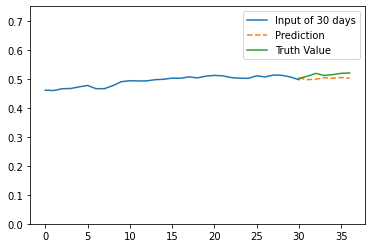

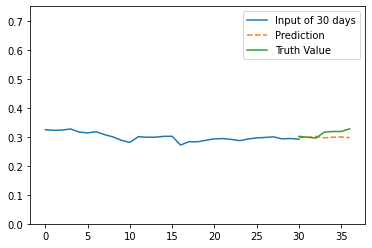

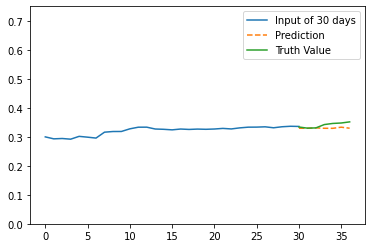

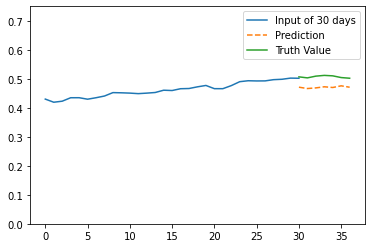

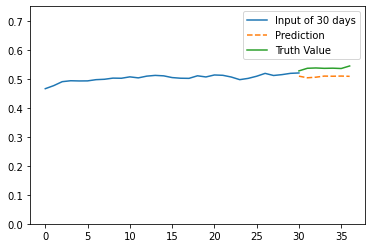

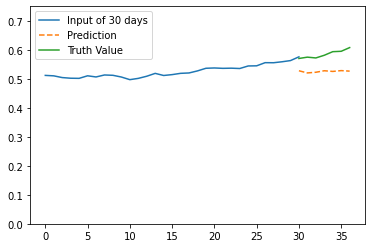

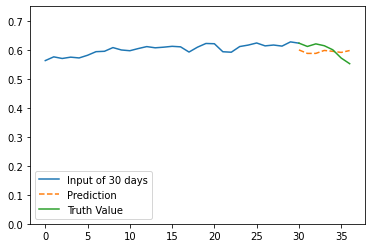

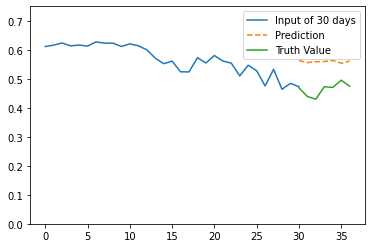

In [25]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = new_model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

**<H2>Issues**

Model Performance is weird although the predictions are good.